# Automated Model Building Leveraging Bayesian Methods

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as tt
from pymc3 import  *
import pymc3 as pm

from tqdm import tqdm_notebook

import pandas as pd
import statsmodels.api as sm

from bambi import Model

from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import warnings
# Suppressing warnings.  It's bad... but they're so annoying 
# and almost always for developers and not me. 
warnings.filterwarnings('ignore')

D:\ProgramData\Anaconda3\envs\bayes\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Introduction

Our goal is develop an automated model building routine give certain constraints. To start, lets list the constraints:
* Model is limited to linear regression or logistic regression with random effects
* Data will be tabular
* Numeric Inputs will be scale-free

The algorithm.  When we take some time to think about what we are trying to implement, it becomes pretty clear that the task we're trying to solve is a simple tree search.  The problem is that as the number of available nodes is quite large and training a single model can take a while, so we would like to be intelligent about the nodes that we visit.  A popular method for approaching this method is Monte Carlo Tree Search. 

The challenge is that MCTS has really been developed and framed in terms of games.  Model building is certainly a type of game, and so far we don't have a reason to believe that the method doesn't fit.  However, one feature of MCTS is the ability to evaluate a position. 

In order to test our method, we will want some datasets to use as well.  To start I think we will use the American National Election Survey from 1996. This dataset, sampled below, has a nice mix of categorical and numeric variables and is a binary classification task.

In [5]:
data = sm.datasets.anes96.load_pandas().data
data['nage'] = (data.age - data.age.mean()) / data.age.std()
data.head()

,popul,TVnews,selfLR,ClinLR,DoleLR,PID,age,educ,income,vote,logpopul,nage
0,0.0,7.0,7.0,1.0,6.0,6.0,36.0,3.0,1.0,1.0,-2.302585,-0.672432
1,190.0,1.0,3.0,3.0,5.0,1.0,20.0,4.0,1.0,0.0,5.247550,-1.646667
2,31.0,7.0,2.0,2.0,6.0,1.0,24.0,6.0,1.0,0.0,3.437208,-1.403108
3,83.0,4.0,3.0,4.0,5.0,1.0,28.0,6.0,1.0,0.0,4.420045,-1.159549
4,640.0,7.0,5.0,6.0,4.0,0.0,68.0,6.0,1.0,0.0,6.461624,1.276040


In [6]:
target = 'vote'
numeric = np.array(['nage'])
categorical = np.array(['educ', 'income'])

def get_ranefs(numeric, categorical):
    '''Generates a list of ranefs
    Given just the list of numeric and categorical variables, we can generate
    a list of all potential features we might explore.
    '''
    random_slopes = [f'0 + {num} | {cat}' for num in numeric for cat in categorical]
    random_linear = [f'1 + {num} | {cat}' for num in numeric for cat in categorical]
    return np.array(random_slopes + random_linear)

ranefs =  get_ranefs(numeric, categorical)
features = np.hstack([numeric, categorical, ranefs])

model_array = np.array([0, 0, 0, 0, 0, 0, 0, 1])
i = len(numeric)
j = len(categorical)
intercept = model_array[0]
selected_numeric = numeric[model_array[1:i+1] == 1]
selected_categorical = categorical[model_array[i+1:i+j+1] == 1]
selected_ranefs = ranefs[model_array[i+j+1:] == 1]

In [7]:
def build_model(model_array, features, target, data):
    """ Builds an arbitrary Bambi model
    
    Args:
      model_array: A vector of boolean values which map to the feature array
      features: A triple of arrays with the string names of variables included in the search
      target: The string name of the target variable
      data: A pandas dataframe with the features and target
    """
    # Pull apart the tuple for convenience
    numeric, categorical, ranefs = features
    numeric, categorical, ranefs = np.array(numeric), np.array(categorical), np.array(ranefs)
    model_array = np.array(model_array)
    
    # Determine which features are in the model
    i = len(numeric)
    j = len(categorical)
    selected_numeric = numeric[model_array[:i] == 1]
    selected_categorical = categorical[model_array[i:i+j] == 1]
    selected_ranefs = ranefs[model_array[i+j:] == 1]
    
    print(f"Fitting with the following features: {selected_numeric}, {selected_categorical}, {selected_ranefs}")
    
    model = Model(data)
    for feature in selected_numeric:
        model.add(feature)
    for feature in selected_categorical:
        model.add(feature, categorical=[feature])
    for feature in selected_ranefs:
        model.add(random=[feature])
    model.add(target + '~ 1')
    results = model.fit(family='bernoulli', progressbar=False)
    return model

def evaluate_model(model):
    waic = pm.waic(model.backend.trace, model.backend.model)
    return waic.WAIC, waic.WAIC_se

At this point, we have the ability to generate an array of binary elements which corresponds to the entire search space, and a function which given that array can fit and evaluate the model.  This is pretty close to what we preliminarily need for Monte Carlo Tree Search.  The only thing to add is the strategy we'll use for searching the tree.

A few different thoughts come to mind:
* Randomly sampling from the search space
  * In this model we would enumerate nodes as we evaluated them, but have no preference for which node we choose.  The best model would be chosen after a fixed amount of time or number of models evaluated.
* Weighted random sampling
  * In this version we would use the WAIC score

To develop the class for MCTS, we will step through what the process might look like manually. 

In [13]:
# The model will be initialized with a number of now expected elements
target = 'vote'
numeric = np.array(['nage'])
categorical = np.array(['educ', 'income'])
# It will probably just internally generate the ranefs for convenience
ranefs =  get_ranefs(numeric, categorical)

In [357]:
n_vars = len(np.hstack([numeric, categorical, ranefs]))
# Initialize model array
model_array = np.zeros(n_vars, np.int32)
model_array

array([0, 0, 0, 0, 0, 0, 0])

In [358]:
# Determine set of next possible models given a model array
model_array = np.array([1, 0, 0, 0, 0, 0, 0])
next_moves = []
for ix, val in enumerate(model_array):
    if val != 1:
        move = model_array.copy()
        move[ix] = 1
        next_moves.append(move)
        
next_moves

[array([1, 1, 0, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 1, 0]),
 array([1, 0, 0, 0, 0, 0, 1])]

In [8]:
def enumerate_node(model_array, models, parent_score=0):
    """Enumerates all possible models which build off of the given model"""
    model_array = np.array(model_array)
    for ix, val in enumerate(model_array):
        if val != 1:
            move = model_array.copy()
            move[ix] = 1
            models = models.append({"models":str(move.astype('int')), "parent_score":parent_score}, ignore_index=True)
    models = models.drop_duplicates(subset="models")
    return models

def best_model(models):
    """Given a dataframe of scores, returns the best"""
    best = models[models.scores == models.scores.min()]
    return best.models.iloc[0]

def random_sampling_strategy(samples):
    """The Random Sampling E.g. No Particular Strategy
    
    In this strategy we start by enumerating the root and giving every model
    equal probability of being chosen.  Then as each model is sampled, we 
    enumerate the possible model from that node. 
    """
    # We start with no possible moves
    models = pd.DataFrame({"models": [], "scores": [], "error": []})
    # We would then enumerate the root to give us the first possible models
    models = enumerate_node(np.zeros(len(numeric) + len(categorical) + len(ranefs)), models)
    for i in range(samples):
        try:
            sample_string = models[np.isnan(models.scores)].sample(1)['models'].iloc[0]
            model_array = np.fromstring(sample_string[1:-1], dtype=int, sep=' ')
            # We then build and evaluate the WAIC of the model
            model = build_model(model_array, (numeric, categorical, ranefs), target, data)
            score = evaluate_model(model)
            # Update the latest score in the models data
            models.loc[models.models == sample_string, "scores"] = score[0]
            models.loc[models.models == sample_string, "error"] = score[1]
            # Since we've evaluated that node, we'll also enumerate the child models
            # of that node and add them to the list of potential models
            models = enumerate_node(model_array, models, parent_score=score[0] + 2*score[1])
        except KeyboardInterrupt:
            raise    
    return models

In [360]:
models = random_sampling_strategy(3)

Fitting with the following features: [], ['income'], []


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 2,047.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, income, Intercept]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: ['nage'], ['income'], []


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Convergence achieved at 19000
Interrupted at 18,999 [37%]: Average Loss = 2,490.2
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, income, nage, Intercept]
The estimated number of effective samples is smaller than 200 for some parameters.


In [469]:
model = build_model(model_array, (numeric, categorical, ranefs), target, data)
model

Fitting with the following features: ['nage'], [], []


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 2,496.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage, Intercept]
The number of effective samples is smaller than 25% for some parameters.


In [479]:
divergent = model.backend.trace['diverging']

divperc = divergent.nonzero()[0].size / len(model.backend.trace) * 100

divperc

0.0

In [9]:
# Time to calculate weights

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def calculate_weights(all_models, root_offset=0):
    """Calculates valid probabilites which sum to one
    
    In our strategy, we want to take into account both the expected
    WAIC and the error in the term.  As a result, we'll calculate 
    actually calculate the upper 95% value, or the mean plus two
    standard deviations.  This will help penalize high variance
    models. 
    """
    # Extracts non-zero parent scores
    models = all_models[np.isnan(all_models.scores)]
    # Calculates mean and std deviation unbiased by zero values
    mean = models[models.parent_score != 0]['parent_score'].mean()
    if all_models[~np.isnan(all_models.scores)].shape[0] == 1:
        std = 1
    else:
        std = models[models.parent_score != 0]['parent_score'].std()
        
    # Calcultes the z scores for each non zero parent score
    # Increase the root offset to make it more likely for the model to try different
    # univariate models. 
    models['Normed'] = [root_offset if score == 0 else (-(score-mean)/std)  for score in models.parent_score]
    models['p'] = softmax(models.Normed)
    return models

In [10]:
def weighted_sampling_strategy(samples):
    """The Weighted Sampling Strategy
    
    In this case we would like to sample from the tree more strategically,
    using some kind of heuristic to guide our sampling as we gain information
    from each evaluated model. 
    
    The primary difference will be that instead of sampling from the possible 
    nodes equally, we'll weight them based on the evaluated WAIC.  To do this we'll
    need to create a calculate_weights function which takes some scores and 
    evaluates valid weights which we can pass to an RNG. 
    """
   # We start with no possible moves
    models = pd.DataFrame({"models": [], "scores": [], "error": []})
    # We would then enumerate the root to give us the first possible models
    models = enumerate_node(np.zeros(len(numeric) + len(categorical) + len(ranefs)), models)
    for i in range(samples):
        try:
            # Calculate Weights
            weights = calculate_weights(models, root_offset=1)
            # Draw Sample
            sample_record = models[np.isnan(models.scores)].sample(1, weights=weights['p'])
            sample_string = sample_record['models'].iloc[0]
            model_array = np.fromstring(sample_string[1:-1], dtype=int, sep=' ')
            #print(model_array)
            # We then build and evaluate the WAIC of the model
            model = build_model(model_array, (numeric, categorical, ranefs), target, data)
            score = evaluate_model(model)
            # Update the latest score in the models data
            models.loc[models.models == sample_string, "scores"] = score[0]
            models.loc[models.models == sample_string, "error"] = score[1]
            # Since we've evaluated that node, we'll also enumerate the child models
            # of that node and add them to the list of potential models
            models = enumerate_node(model_array, models, parent_score=score[0] + 2*score[1])
        except KeyboardInterrupt:
            raise    
    return models

In [366]:
models = weighted_sampling_strategy(3)

[0 0 0 1 0 0 0]
Fitting with the following features: [], [], ['0 + nage | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19400
Interrupted at 19,399 [38%]: Average Loss = 1,425
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| educ_offset, nage| educ_sd]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 0 1 0]
Fitting with the following features: [], [], ['1 + nage | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19400
Interrupted at 19,399 [38%]: Average Loss = 1,523.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| educ_offset, nage| educ_sd, 1| educ_offset, 1| educ_sd]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 1 0 1 0]
Fitting with the following features: [], [], ['0 + nage | educ' '1 + nage | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 18900
Interrupted at 18,899 [37%]: Average Loss = 1,539.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, 1| educ_offset, 1| educ_sd, nage| educ_offset, nage| educ_sd]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [367]:
models.sort_values("scores")

,models,scores,error,parent_score
5,[0 0 0 0 0 1 0],1343.087952,12.030390,0.000000
11,[0 0 0 1 0 1 0],1343.116178,12.064732,1366.853772
16,[0 0 0 1 0 1 0],1343.116178,12.064732,1367.148732
3,[0 0 0 1 0 0 0],1343.747162,11.553305,0.000000
0,[1 0 0 0 0 0 0],NaN,NaN,0.000000
1,[0 1 0 0 0 0 0],NaN,NaN,0.000000
2,[0 0 1 0 0 0 0],NaN,NaN,0.000000
4,[0 0 0 0 1 0 0],NaN,NaN,0.000000
6,[0 0 0 0 0 0 1],NaN,NaN,0.000000
7,[1 0 0 1 0 0 0],NaN,NaN,1366.853772


Up to this point we've only been testing with *3 variables*.  I think it's time to turn it up a notch, and see it handles more variables.

In [11]:
# The model will be initialized with a number of now expected elements
target = 'vote'


numeric = np.array(['nage', 'logpopul'])
categorical = np.array(['educ', 'income', 'PID', 'selfLR'])
# It will probably just internally generate the ranefs for convenience
ranefs =  get_ranefs(numeric, categorical)

In [369]:
models = weighted_sampling_strategy(20)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Fitting with the following features: [], [], ['0 + logpopul | income']


INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19300
Interrupted at 19,299 [38%]: Average Loss = 1,582.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| income_offset, logpopul| income_sd]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitting with the following features: [], ['PID'], []


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 1,279.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, PID, Intercept]


[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Fitting with the following features: [], [], ['0 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 1,868.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| selfLR_offset, logpopul| selfLR_sd]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitting with the following features: [], [], ['0 + nage | income']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19400
Interrupted at 19,399 [38%]: Average Loss = 1,437.4
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| income_offset, nage| income_sd]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Fitting with the following features: [], [], ['1 + nage | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 1,011.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitting with the following features: [], [], ['0 + nage | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19800
Interrupted at 19,799 [39%]: Average Loss = 1,434
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| educ_offset, nage| educ_sd]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Fitting with the following features: [], ['PID'], ['1 + nage | income']


INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 1,248.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| income_offset, nage| income_sd, 1| income_offset, 1| income_sd, PID, Intercept]
The number of effective samples is smaller than 25% for some parameters.


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Fitting with the following features: [], ['PID'], ['1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 1,334.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, PID, Intercept]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Fitting with the following features: [], ['educ' 'PID'], ['1 + logpopul | selfLR']


INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 25100
Interrupted at 25,099 [50%]: Average Loss = 1,784
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, PID, educ, Intercept]
The number of effective samples is smaller than 25% for some parameters.


[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
Fitting with the following features: [], ['educ' 'PID'], ['1 + logpopul | income' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 2,026.6
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, PID, educ, Intercept]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
Fitting with the following features: [], ['educ' 'PID'], ['1 + nage | income' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 2,097.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| income_offset, nage| income_sd, 1| income_offset, 1| income_sd, PID, educ, Intercept]
The estimated number of effective samples is smaller than 200 for some parameters.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Fitting with the following features: [], ['PID'], ['1 + logpopul | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 1,304.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| PID_offset, logpopul| PID_sd, 1| PID_offset, 1| PID_sd, PID, Intercept]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.635539885527753, but should be close to 0.8. Try to increase the number of tuning steps.
There were 907 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31780144076287675, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
Fitting with the following features: [], ['PID'], ['1 + nage | income' '1 + nage | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 1,359.9
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| income_offset, nage| income_sd, 1| income_offset, 1| income_sd, PID, Intercept]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Fitting with the following features: [], ['income' 'PID'], ['1 + nage | income']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 1,747.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| income_offset, nage| income_sd, 1| income_offset, 1| income_sd, PID, income, Intercept]
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6793447308206073, but should be close to 0.8. Try to increase the number of tuning steps.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6507623216419204, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is large

[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
Fitting with the following features: [], ['educ' 'PID'], ['1 + logpopul | income' '1 + logpopul | PID' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Convergence achieved at 26200
Interrupted at 26,199 [52%]: Average Loss = 2,044.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, logpopul| PID_offset, logpopul| PID_sd, 1| PID_offset, 1| PID_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, PID, educ, Intercept]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7157034995752866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective sam

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitting with the following features: [], ['income'], []


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19000
Interrupted at 18,999 [37%]: Average Loss = 1,918.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, income, Intercept]
The estimated number of effective samples is smaller than 200 for some parameters.


[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]
Fitting with the following features: [], ['educ' 'PID'], ['1 + nage | PID' '1 + logpopul | income' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 2,303.7
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, PID, educ, Intercept]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock


[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0]
Fitting with the following features: [], ['PID'], ['0 + nage | PID' '1 + nage | income' '1 + nage | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22700
Interrupted at 22,699 [45%]: Average Loss = 1,440.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, 1| PID_offset, 1| PID_sd, nage| income_offset, nage| income_sd, 1| income_offset, 1| income_sd, nage| PID_offset, nage| PID_sd, PID, Intercept]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock


[0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
Fitting with the following features: [], ['educ' 'PID'], ['1 + nage | educ' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 26300
Interrupted at 26,299 [52%]: Average Loss = 1,913.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| educ_offset, nage| educ_sd, 1| educ_offset, 1| educ_sd, PID, educ, Intercept]
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
Fitting with the following features: [], ['PID'], ['0 + nage | selfLR' '1 + logpopul | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexander\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_63_Stepping_2_GenuineIntel-3.6.5-64\lock_dir\lock
Convergence achieved at 21800
Interrupted at 21,799 [43%]: Average Loss = 1,371
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| PID_offset, logpopul| PID_sd, 1| PID_offset, 1| PID_sd, nage| selfLR_offset, nage| selfLR_sd, PID, Intercept]
There were 886 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.02504323089484991, but should be close to 0.8. Try to increase the number of tuning steps.
There were 911 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3737059451330113, but should be close to 0.8. Try to increase the number of tuning steps.
The gelma

In [438]:
weights = calculate_weights(models.sort_values('scores'))
models

,models,scores,error,parent_score,Normed
0,[1 0 0 0 0 0 0],NaN,NaN,0.000000,0.000000
1,[0 1 0 0 0 0 0],1347.364258,12.588133,0.000000,0.000000
2,[0 0 1 0 0 0 0],1344.256783,16.392886,0.000000,0.000000
3,[0 0 0 1 0 0 0],NaN,NaN,0.000000,0.000000
4,[0 0 0 0 1 0 0],NaN,NaN,0.000000,0.000000
5,[0 0 0 0 0 1 0],NaN,NaN,0.000000,0.000000
6,[0 0 0 0 0 0 1],NaN,NaN,0.000000,0.000000
7,[1 1 0 0 0 0 0],NaN,NaN,1372.540524,0.801798
8,[0 1 1 0 0 0 0],NaN,NaN,1372.540524,0.801798
9,[0 1 0 1 0 0 0],NaN,NaN,1372.540524,0.801798


In [407]:
train_data = models[~np.isnan(models.scores)]
test_data = models[np.isnan(models.scores)]

X_train = np.vstack(train_data.models.map(lambda x: np.fromstring(x[1:-1], dtype=int, sep=' ')).tolist())
X_test = np.vstack(test_data.models.map(lambda x: np.fromstring(x[1:-1], dtype=int, sep=' ')).tolist())

mean = train_data['scores'].mean()
std = train_data['scores'].std()

train_data['Normed'] = [0 if score == 0 else (-(score-mean)/std) for score in train_data.scores]
y_train = train_data.Normed.values

X_train, y_train

(array([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0]]),
 array([-0.57283494,  1.1546888 , -0.58185386]))

In [419]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)
test_data['predictions'] = clf.predict(X_test)
test_data

,models,scores,error,parent_score,Normed,predictions
0,[1 0 0 0 0 0 0],NaN,NaN,0.000000,0.000000,0.210763
3,[0 0 0 1 0 0 0],NaN,NaN,0.000000,0.000000,0.210763
4,[0 0 0 0 1 0 0],NaN,NaN,0.000000,0.000000,0.050436
5,[0 0 0 0 0 1 0],NaN,NaN,0.000000,0.000000,0.210763
6,[0 0 0 0 0 0 1],NaN,NaN,0.000000,0.000000,0.210763
7,[1 1 0 0 0 0 0],NaN,NaN,1372.540524,0.801798,-0.261199
8,[0 1 1 0 0 0 0],NaN,NaN,1372.540524,0.801798,0.210763
9,[0 1 0 1 0 0 0],NaN,NaN,1372.540524,0.801798,-0.261199
11,[0 1 0 0 0 1 0],NaN,NaN,1372.540524,0.801798,-0.261199
12,[0 1 0 0 0 0 1],NaN,NaN,1372.540524,0.801798,-0.261199


In [443]:
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)
test_data['predictions'] = svm.predict(X_test)
test_data

,models,scores,error,parent_score,Normed,predictions
0,[1 0 0 0 0 0 0],NaN,NaN,0.000000,0.000000,0.290927
3,[0 0 0 1 0 0 0],NaN,NaN,0.000000,0.000000,0.290927
4,[0 0 0 0 1 0 0],NaN,NaN,0.000000,0.000000,0.281908
5,[0 0 0 0 0 1 0],NaN,NaN,0.000000,0.000000,0.290927
6,[0 0 0 0 0 0 1],NaN,NaN,0.000000,0.000000,0.290927
7,[1 1 0 0 0 0 0],NaN,NaN,1372.540524,0.801798,-0.472835
8,[0 1 1 0 0 0 0],NaN,NaN,1372.540524,0.801798,0.290927
9,[0 1 0 1 0 0 0],NaN,NaN,1372.540524,0.801798,-0.472835
11,[0 1 0 0 0 1 0],NaN,NaN,1372.540524,0.801798,-0.472835
12,[0 1 0 0 0 0 1],NaN,NaN,1372.540524,0.801798,-0.472835


In [447]:
models.loc[np.isnan(models.scores)].shape

(21, 5)

In [452]:
models.loc[np.isnan(models.scores)]['Normed'] = svm.predict(X_test)

In [454]:
svm.predict(X_test)

array([ 0.29092693,  0.29092693,  0.281908  ,  0.29092693,  0.29092693,
       -0.47283494,  0.29092693, -0.47283494, -0.47283494, -0.47283494,
        1.0546888 ,  0.29092693,  1.0546888 ,  1.04566987,  1.0546888 ,
        1.0546888 , -0.48185386,  0.281908  , -0.48185386, -0.48185386,
       -0.48185386])

In [12]:
def predict_weights(all_models, svm, root_offset=1):
    """Calculates valid probabilites which sum to one
    
    In our strategy, we want to take into account both the expected
    WAIC and the error in the term.  As a result, we'll calculate 
    actually calculate the upper 95% value, or the mean plus two
    standard deviations.  This will help penalize high variance
    models. 
    """
    # Extracts non-zero parent scores
    models = all_models[np.isnan(all_models.scores)]
    arr = np.vstack(models.models.map(lambda x: np.fromstring(x[1:-1], dtype=int, sep=' ')).tolist())
    # Calculates mean and std deviation unbiased by zero values
    models['pred'] = svm.predict(arr)
    # Root offset helps incentive the model to give the root 
    # variables an opportunity to be run by themselves
    models['pred'] = np.where(models.parent_score == 0, models.pred + root_offset, models.pred)
    models['p'] = softmax(models.pred)
    return models

def train_model(all_models):
    # Get all nodes which have been evaluated
    train_data = all_models[~np.isnan(all_models.scores)]
    # Get an input matrix from the model column
    X_train = np.vstack(train_data.models.map(lambda x: np.fromstring(x[1:-1], dtype=int, sep=' ')).tolist())
    # Precalculate normalization values
    mean = train_data['scores'].mean()
    std = train_data['scores'].std()
    # Norm values
    train_data['Normed'] = [0 if score == 0 else (-(score-mean)/std) for score in train_data.scores]
    y_train = train_data.Normed.values
    # Create instance of support vector machine with linear kernal
    svm = SVR(kernel='linear')
    # train it
    svm.fit(X_train, y_train)    
    return svm

def predictive_sampling_strategy(samples):
    """The Predictive Sampling Strategy
    
    In this model we enhance our weight mechanism with predictions from
    a support vector machine for our weights instead the heuristic that's
    based on their parent score. 
    
    This will hopefully help us identify related nodes in the tree and 
    prioritize them automatically. What's kind of cool too is that we don't really 
    need to change our method too much. 
    """
   # We start with no possible moves
    models = pd.DataFrame({"models": [], "scores": [], "error": []})
    # We would then enumerate the root to give us the first possible models
    models = enumerate_node(np.zeros(len(numeric) + len(categorical) + len(ranefs)), models)
    # We want to observe the sampling pattern, so we'll also track each iteration
    # in a trace.
    trace = pd.DataFrame({"iter": [], "model": [], "score": [], "error": []})
    for i in range(samples):
        try:
            if (i > 0) & (i % 3 == 0):
                svm = train_model(models)
            # While we have yet had enough iterations to have 
            # trained a model, use our weighted strategy from
            # before
            if i < 3:
                weights = calculate_weights(models, root_offset=1)
            else:
                weights = predict_weights(models, svm, root_offset=1)
            # Draw Sample
            sample_record = models[np.isnan(models.scores)].sample(1, weights=weights['p'])
            sample_string = sample_record['models'].iloc[0]
            model_array = np.fromstring(sample_string[1:-1], dtype=int, sep=' ')
            #print(model_array)
            # We then build and evaluate the WAIC of the model
            model = build_model(model_array, (numeric, categorical, ranefs), target, data)
            score = evaluate_model(model)
            # Update the latest score in the models data
            models.loc[models.models == sample_string, "scores"] = score[0]
            models.loc[models.models == sample_string, "error"] = score[1]
            # Since we've evaluated that node, we'll also enumerate the child models
            # of that node and add them to the list of potential models
            models = enumerate_node(model_array, models, parent_score=score[0] + 2*score[1])
            # Add values to trace
            trace = trace.append({"iter": i, "model": sample_string, "score": score[0], "error": score[1]}, ignore_index=True)
        except KeyboardInterrupt:
            raise    
    return models, svm, trace

In [15]:
%%time
models, svm, trace = predictive_sampling_strategy(30)

Fitting with the following features: [], [], ['0 + logpopul | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19300
Interrupted at 19,299 [38%]: Average Loss = 1,588.7
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| educ_offset, logpopul| educ_sd]
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: [], [], ['1 + nage | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 20000
Interrupted at 19,999 [39%]: Average Loss = 1,465.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| educ_offset, nage| educ_sd, 1| educ_offset, 1| educ_sd]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['1 + logpopul | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19100
Interrupted at 19,099 [38%]: Average Loss = 1,546.2
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| educ_offset, logpopul| educ_sd, 1| educ_offset, 1| educ_sd]
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: [], [], ['1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 21000
Interrupted at 20,999 [41%]: Average Loss = 1,269.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd]
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: [], [], ['0 + nage | income' '1 + logpopul | educ']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 20500
Interrupted at 20,499 [40%]: Average Loss = 1,634.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| educ_offset, logpopul| educ_sd, 1| educ_offset, 1| educ_sd, nage| income_offset, nage| income_sd]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: [], [], ['0 + logpopul | educ' '0 + logpopul | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 1,426
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| PID_offset, logpopul| PID_sd, logpopul| educ_offset, logpopul| educ_sd]
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: [], [], ['1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 1,105.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['1 + nage | PID' '1 + nage | selfLR' '1 + logpopul | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 1,244.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| PID_offset, logpopul| PID_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['0 + logpopul | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 1,445
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, logpopul| PID_offset, logpopul| PID_sd]
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: [], [], ['1 + nage | PID' '1 + nage | selfLR' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 1,217.4
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| selfLR_offset, logpopul| selfLR_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['0 + logpopul | educ' '1 + nage | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 1,037.7
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, logpopul| educ_offset, logpopul| educ_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], ['selfLR'], ['1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 28000
Interrupted at 27,999 [55%]: Average Loss = 1,702.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, selfLR, Intercept]
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5375656346905932, but should be close to 0.8. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6110488311316471, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 f

Fitting with the following features: [], ['selfLR'], ['0 + nage | educ' '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 25900
Interrupted at 25,899 [51%]: Average Loss = 1,839.4
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| educ_offset, nage| educ_sd, selfLR, Intercept]
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43957414405843964, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1094 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31167177928132145, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is

Fitting with the following features: [], ['income'], ['1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 1,851.9
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, income, Intercept]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], ['selfLR'], ['0 + nage | income' '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 28200
Interrupted at 28,199 [56%]: Average Loss = 1,751.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| income_offset, nage| income_sd, selfLR, Intercept]
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7042851636468548, but should be close to 0.8. Try to increase the number of tuning steps.
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6506256942017085, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of 

Fitting with the following features: [], ['income'], ['0 + nage | income' '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 22700
Interrupted at 22,699 [45%]: Average Loss = 1,933
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| income_offset, nage| income_sd, income, Intercept]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['0 + nage | selfLR' '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 1,075.2
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| selfLR_offset, nage| selfLR_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], ['income'], ['0 + nage | income' '1 + nage | income' '1 + nage | PID'
 '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 1,952.7
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, 1| income_offset, 1| income_sd, nage| income_offset, nage| income_sd, income, Intercept]
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6440175854286896, but should be close to 0.8. Try to increase the number of tuning steps.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6571618700268025, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Fitting with the following features: [], ['income'], ['0 + nage | income' '0 + nage | selfLR' '1 + nage | income'
 '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 1,973.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, 1| income_offset, 1| income_sd, nage| selfLR_offset, nage| selfLR_sd, nage| income_offset, nage| income_sd, income, Intercept]
There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39500704389300423, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], ['income'], ['1 + nage | PID' '1 + nage | selfLR' '1 + logpopul | income']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 2,152.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, income, Intercept]
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], ['selfLR'], ['0 + nage | educ' '1 + nage | PID' '1 + nage | selfLR'
 '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 1,932.6
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| selfLR_offset, logpopul| selfLR_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| educ_offset, nage| educ_sd, selfLR, Intercept]
There were 968 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.07228703938352683, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1093 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3326869908070092, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.

Fitting with the following features: [], ['income'], ['0 + nage | income' '0 + logpopul | PID' '1 + nage | income'
 '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 2,070.8
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, 1| income_offset, 1| income_sd, logpopul| PID_offset, logpopul| PID_sd, nage| income_offset, nage| income_sd, income, Intercept]
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 870 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4024205093916569, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: ['nage'], ['selfLR'], ['0 + nage | educ' '1 + nage | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 29500
Interrupted at 29,499 [58%]: Average Loss = 2,047.2
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| educ_offset, nage| educ_sd, selfLR, nage, Intercept]
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6949984636056932, but should be close to 0.8. Try to increase the number of tuning steps.
There were 292 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6851644825498091, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: ['nage'], ['selfLR'], ['0 + nage | educ' '1 + nage | PID' '1 + nage | selfLR'
 '1 + logpopul | income']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 30000
Interrupted at 29,999 [59%]: Average Loss = 2,298.5
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| educ_offset, nage| educ_sd, selfLR, nage, Intercept]
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41211827866744527, but should be close to 0.8. Try to increase the number of tuning steps.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5510695087682173, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some para

Fitting with the following features: [], [], ['0 + logpopul | selfLR' '1 + nage | PID' '1 + nage | selfLR'
 '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 1,239
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, logpopul| selfLR_offset, logpopul| selfLR_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['0 + nage | selfLR' '1 + nage | PID' '1 + nage | selfLR'
 '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 1,221.7
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| selfLR_offset, logpopul| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, nage| selfLR_offset, nage| selfLR_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: [], [], ['0 + logpopul | income' '0 + logpopul | PID' '1 + nage | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 21300
Interrupted at 21,299 [42%]: Average Loss = 1,501.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, logpopul| PID_offset, logpopul| PID_sd, logpopul| income_offset, logpopul| income_sd]
The number of effective samples is smaller than 25% for some parameters.


Fitting with the following features: ['nage'], ['selfLR'], ['0 + nage | educ' '0 + logpopul | PID' '1 + nage | PID'
 '1 + nage | selfLR' '1 + logpopul | income']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 28500
Interrupted at 28,499 [56%]: Average Loss = 2,438.3
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, logpopul| PID_offset, logpopul| PID_sd, nage| educ_offset, nage| educ_sd, selfLR, nage, Intercept]
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7144210137957276, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3786571853463083, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin st

Fitting with the following features: [], [], ['0 + logpopul | selfLR' '1 + nage | PID' '1 + nage | selfLR'
 '1 + logpopul | PID' '1 + logpopul | selfLR']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 1,322.7
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, Intercept, logpopul| PID_offset, logpopul| PID_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, logpopul| selfLR_offset, logpopul| selfLR_sd]
The estimated number of effective samples is smaller than 200 for some parameters.


Fitting with the following features: ['nage'], ['selfLR'], ['0 + nage | educ' '0 + logpopul | PID' '1 + nage | PID'
 '1 + nage | selfLR' '1 + logpopul | income' '1 + logpopul | PID']


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Convergence achieved at 30000
Interrupted at 29,999 [59%]: Average Loss = 2,431.2
Sequential sampling (2 chains in 1 job)
NUTS: [vote_sd, logpopul| income_offset, logpopul| income_sd, 1| income_offset, 1| income_sd, nage| selfLR_offset, nage| selfLR_sd, 1| selfLR_offset, 1| selfLR_sd, nage| PID_offset, nage| PID_sd, 1| PID_offset, 1| PID_sd, logpopul| PID_offset, logpopul| PID_sd, nage| educ_offset, nage| educ_sd, selfLR, nage, Intercept]
There were 871 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.01635184013012039, but should be close to 0.8. Try to increase the number of tuning steps.
There were 928 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4254920771941988, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin st

Wall time: 59min 28s


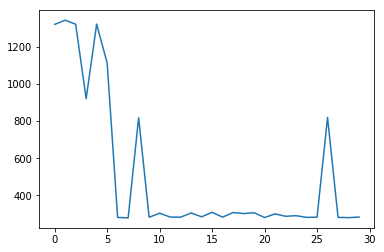

In [17]:
trace.score.plot()

In [18]:
trace

,iter,model,score,error
0,0.0,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0],1321.227344,14.385184
1,1.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0],1343.504695,12.027565
2,2.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],1322.004579,14.601432
3,3.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0],920.632495,41.675683
4,4.0,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0],1322.644436,14.746603
5,5.0,[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0],1113.154033,27.550883
6,6.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0],280.872928,78.817142
7,7.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0],278.098293,79.103181
8,8.0,[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0],817.500664,42.984697
9,9.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1],281.732932,78.764144


In [19]:
predict_weights(models, svm).sort_values("p")

,models,scores,error,parent_score,pred,p
113,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0],NaN,NaN,1352.137643,-2.166257,0.000180
59,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0],NaN,NaN,1367.559825,-2.165473,0.000181
50,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0],NaN,NaN,1367.559825,-1.885414,0.000239
46,[0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0],NaN,NaN,1367.559825,-1.884631,0.000239
60,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0],NaN,NaN,1367.559825,-1.884631,0.000239
56,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0],NaN,NaN,1367.559825,-1.884631,0.000239
55,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0],NaN,NaN,1367.559825,-1.884631,0.000239
53,[0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0],NaN,NaN,1367.559825,-1.884631,0.000239
35,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0],NaN,NaN,1349.997713,-1.884631,0.000239
52,[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0],NaN,NaN,1367.559825,-1.884631,0.000239


In [ ]:
class mcts(object):
    
    def __init__(self, numeric, categorical, target):
        self.target = target
        self.numeric = np.array(numeric)
        self.categorical = np.array(categorical)
        self.ranefs = self.get_ranefs(numeric, categorical)
        self.n_numeric = len(numeric)
        self.n_categorical = len(categorical)
        self.n_vars = len(numeric) + len(categorical) + len(self.ranefs)
        self.root_node = np.zeros(self.n_vars, np.int32)
        
    
    def enumerate_node(self, model_array, models, parent_score=0):
        """Enumerates all possible models which build off of the given model"""
        model_array = np.array(model_array)
        for ix, val in enumerate(model_array):
            if val != 1:
                move = model_array.copy()
                move[ix] = 1
                models = models.append({"models":str(move.astype('int')), "parent_score":parent_score}, ignore_index=True)
        return models
    
    @staticmethod
    def get_ranefs(numeric, categorical):
        '''Generates a list of ranefs
        Given just the list of numeric and categorical variables, we can generate
        a list of all potential features we might explore.
        '''
        random_slopes = [f'0 + {num} | {cat}' for num in numeric for cat in categorical]
        random_linear = [f'1 + {num} | {cat}' for num in numeric for cat in categorical]
        return np.array(random_slopes + random_linear)
    
    

In [151]:
search = mcts(numeric, categorical, target)
search.model_array

array([0, 0, 0, 0, 0, 0, 0])